# Merge Colonies Datasets

## Join Delhi+NDMC+JJC and UAC shapefiles

Tasks:
* Import both shapefiles **[DONE]**
* Project them to the same CRS **[DONE]**
* Harmonize columns **[DONE]**
* Find max USO ID for Delhi+NDMC+JJC **[DONE]**
* Create new ID for UACs **[DONE]**
* Merge UACs with Delhi+NDMC+JJC **[DONE]**
* Save shapefile **[DONE]**
* Attempt to open shapefile in QGIS **[DONE]**

In [48]:
# import modules
import pickle
import pandas as pd
import geopandas as gpd
from pyproj import CRS

# Import both shapefiles

In [2]:
delhi_ndmc_jjc = gpd.read_file("delhi_ndmc_jjc_corrected.shp")

In [3]:
uac = gpd.read_file("uac_deduplicated_31july2020.shp")

# Reproject to CRS: EPSG 3857

Check CRS

In [6]:
delhi_ndmc_jjc.crs

<Projected CRS: EPSG:7760>
Name: WGS 84 / Delhi
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - Delhi
- bounds: (76.83, 28.4, 77.34, 28.89)
Coordinate Operation:
- name: Delhi NSF LCC
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
uac.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Change CRS

In [8]:
# WGS 84 / Delhi
epsg_code = 3857

# Define CRS in WKT format using EPSG code
target_projection = CRS.from_epsg(epsg_code).to_wkt()
    
# Reproject shapefiles to epsg_code
delhi_ndmc_jjc = delhi_ndmc_jjc.to_crs(target_projection)
uac = uac.to_crs(target_projection)

In [12]:
uac.crs == delhi_ndmc_jjc.crs

True

# Visualize shapefiles and view GeoDataFrames

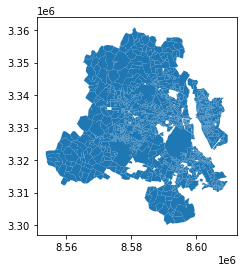

In [13]:
delhi_ndmc_jjc.plot()

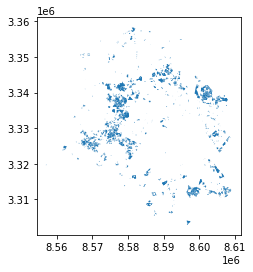

In [14]:
uac.plot()

In [15]:
delhi_ndmc_jjc.head()

,AREA,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry
0,Singhola,3058,H,RV,"POLYGON Z ((8587300.847 3355178.518 0.000, 858..."
1,Indra Colony (Narela),1760,G,RUAC,"POLYGON Z ((8580725.093 3357134.173 0.000, 858..."
2,Bhor Garh,1276,H,Industrial,"POLYGON Z ((8581345.143 3353980.079 0.000, 858..."
3,Gautam Colony,1528,G,RUAC,"POLYGON Z ((8580819.492 3356801.814 0.000, 858..."
4,Kureni,2082,H,RV,"POLYGON Z ((8582448.764 3356971.996 0.000, 858..."


In [17]:
delhi_ndmc_jjc.columns

Index(['AREA', 'USO_AREA_U', 'HOUSETAX_C', 'USO_FINAL', 'geometry'], dtype='object')

In [19]:
uac.head()

,map_no,registrati,fme_databa,index,geometry
0,520,570,D:\UC Downloads\UC_501-600-Done\520_570.pdf,0,"POLYGON ((8568698.722 3350778.289, 8568688.910..."
1,509,888,D:\UC Downloads\UC_501-600-Done\509_888.pdf,1,"POLYGON ((8580894.912 3343225.741, 8580905.114..."
2,516,658,D:\UC Downloads\UC_501-600-Done\516_658.pdf,2,"POLYGON ((8574843.534 3349736.689, 8574924.630..."
3,503,200,D:\UC Downloads\UC_501-600-Done\503_200.pdf,3,"POLYGON ((8578433.979 3352949.941, 8578436.107..."
4,504,1194,D:\UC Downloads\UC_501-600-Done\504_1194.pdf,4,"POLYGON ((8579255.777 3353628.687, 8579180.169..."


In [20]:
uac.columns

Index(['map_no', 'registrati', 'fme_databa', 'index', 'geometry'], dtype='object')

## Harmonize Columns
* UAC
    * Remove `map_no`, `registrati`, `fme_databa`, and `index` **[DONE]**
    * Add `USO_AREA_U` column **[DONE]**
    * Add `USO_FINAL` column with UAC class (find what Bijoy codes this as)
    * Add `HOUSETAX_C` column with code for non-NDMC (find out what Bijoy codes this as)
* Delhi/NDMC/JJC
    * Remove `Area` column
* Make sure only columns in both GeoDataFrames are `USO_AREA_U`, `HOUSETAX_C`, `USO_FINAL`, and `geometry`

### Unique values for `USO_FINAL`

In [21]:
delhi_ndmc_jjc['USO_FINAL'].unique()

array(['RV', 'RUAC', 'Industrial', 'UV', 'UAC1', 'Planned', 'Other',
       'SDA', 'Institutional', 'JJR', 'Commercial', 'JJC1', 'DCB', 'NDMC',
       'JJC2'], dtype=object)

Code UACs' `USO_FINAL` as 'UAC2'

### Unique values for `HOUSETAX_C`

In [22]:
delhi_ndmc_jjc['HOUSETAX_C'].unique()

array(['H', 'G', 'D', 'E', 'C', 'F', 'B', 'A', None], dtype=object)

Code UACs' `HOUSETAX_C` as None

### Remove extraneous columns from `uac`

In [23]:
uac = uac.drop(columns=['map_no', 'registrati', 'fme_databa', 'index'])

In [24]:
uac.head(2)

,geometry
0,"POLYGON ((8568698.722 3350778.289, 8568688.910..."
1,"POLYGON ((8580894.912 3343225.741, 8580905.114..."


### Create new USO ID for UACs

In [30]:
# Find the highest value of USO_Index for Delhi+NDMC+JJC data
delhi_ndmc_jjc['USO_AREA_U'].max()

4070

In [31]:
# Initialize USO_AREA_U column with -1
uac['USO_AREA_U'] = -1

In [32]:
# Set beginning of USO AREA Code for JJCs to be 5001
uso_area_code = 5001

# Iterate through all UAC rows
for idx, row in uac.iterrows():
    
    # Set USO_AREA_U to code beginning at 5001
    uac.loc[idx, 'USO_AREA_U'] = uso_area_code
    
    # Increment USO_AREA_U code
    uso_area_code += 1

In [33]:
uac.head()

,geometry,USO_AREA_U
0,"POLYGON ((8568698.722 3350778.289, 8568688.910...",5001
1,"POLYGON ((8580894.912 3343225.741, 8580905.114...",5002
2,"POLYGON ((8574843.534 3349736.689, 8574924.630...",5003
3,"POLYGON ((8578433.979 3352949.941, 8578436.107...",5004
4,"POLYGON ((8579255.777 3353628.687, 8579180.169...",5005


In [34]:
uac.tail()

,geometry,USO_AREA_U
1508,"POLYGON ((8603999.322 3332808.838, 8604078.548...",6509
1509,"POLYGON ((8576522.039 3336941.191, 8576576.418...",6510
1510,"POLYGON ((8576663.032 3336801.506, 8576647.696...",6511
1511,"POLYGON ((8575193.159 3341022.052, 8575195.388...",6512
1512,"POLYGON ((8574830.088 3341549.589, 8574827.767...",6513


### Create `USO_FINAL` column with category `UAC2`

In [35]:
uac['USO_FINAL'] = 'UAC2'

In [36]:
uac.head(2)

,geometry,USO_AREA_U,USO_FINAL
0,"POLYGON ((8568698.722 3350778.289, 8568688.910...",5001,UAC2
1,"POLYGON ((8580894.912 3343225.741, 8580905.114...",5002,UAC2


In [37]:
uac.tail(2)

,geometry,USO_AREA_U,USO_FINAL
1511,"POLYGON ((8575193.159 3341022.052, 8575195.388...",6512,UAC2
1512,"POLYGON ((8574830.088 3341549.589, 8574827.767...",6513,UAC2


### Create `HOUSETAX_C` column with value `None`

In [38]:
uac['HOUSETAX_C'] = None

In [39]:
uac.head()

,geometry,USO_AREA_U,USO_FINAL,HOUSETAX_C
0,"POLYGON ((8568698.722 3350778.289, 8568688.910...",5001,UAC2,None
1,"POLYGON ((8580894.912 3343225.741, 8580905.114...",5002,UAC2,None
2,"POLYGON ((8574843.534 3349736.689, 8574924.630...",5003,UAC2,None
3,"POLYGON ((8578433.979 3352949.941, 8578436.107...",5004,UAC2,None
4,"POLYGON ((8579255.777 3353628.687, 8579180.169...",5005,UAC2,None


In [40]:
uac.tail()

,geometry,USO_AREA_U,USO_FINAL,HOUSETAX_C
1508,"POLYGON ((8603999.322 3332808.838, 8604078.548...",6509,UAC2,None
1509,"POLYGON ((8576522.039 3336941.191, 8576576.418...",6510,UAC2,None
1510,"POLYGON ((8576663.032 3336801.506, 8576647.696...",6511,UAC2,None
1511,"POLYGON ((8575193.159 3341022.052, 8575195.388...",6512,UAC2,None
1512,"POLYGON ((8574830.088 3341549.589, 8574827.767...",6513,UAC2,None


### Remove `Area` column from Delhi+NDMC+JJC

In [41]:
delhi_ndmc_jjc = delhi_ndmc_jjc.drop(columns=['AREA'])

In [42]:
delhi_ndmc_jjc.head()

,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry
0,3058,H,RV,"POLYGON Z ((8587300.847 3355178.518 0.000, 858..."
1,1760,G,RUAC,"POLYGON Z ((8580725.093 3357134.173 0.000, 858..."
2,1276,H,Industrial,"POLYGON Z ((8581345.143 3353980.079 0.000, 858..."
3,1528,G,RUAC,"POLYGON Z ((8580819.492 3356801.814 0.000, 858..."
4,2082,H,RV,"POLYGON Z ((8582448.764 3356971.996 0.000, 858..."


### Merge UAC and Delhi+NDMC+JJC

In [43]:
# Concatenate both GeoDataFrames (using pd.concat)
# and created combined GeoDataFrame with same crs as delhi_ndmc_jjc (EPSG 3857)
colonies = gpd.GeoDataFrame(pd.concat([delhi_ndmc_jjc, uac], ignore_index=True), crs=delhi_ndmc_jjc.crs)

In [44]:
colonies.head()

,USO_AREA_U,HOUSETAX_C,USO_FINAL,geometry
0,3058,H,RV,"POLYGON Z ((8587300.847 3355178.518 0.000, 858..."
1,1760,G,RUAC,"POLYGON Z ((8580725.093 3357134.173 0.000, 858..."
2,1276,H,Industrial,"POLYGON Z ((8581345.143 3353980.079 0.000, 858..."
3,1528,G,RUAC,"POLYGON Z ((8580819.492 3356801.814 0.000, 858..."
4,2082,H,RV,"POLYGON Z ((8582448.764 3356971.996 0.000, 858..."


In [45]:
# check number of columns
len(colonies)

4324

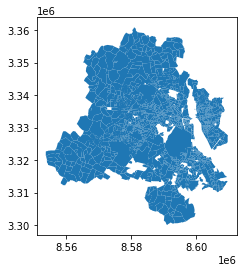

In [46]:
colonies.plot()

# Save Combined Shapefile

In [47]:
colonies.to_file("colonies_31july2020.shp")

In [49]:
with open('colonies_31july2020.data', 'wb') as f:
    pickle.dump(colonies, f)